# Color Blend Algorithm

> I hate my previous work because it is too messy. Too many epic, media, grumble words. I want to start fresh. Much for academic and research purpose. The previous one would be stay as it is for archive. Try to browse #20bdcc5567ba46df0daf7d40de80dc73fc3df9fa

Let's start. What I wish for?
- I want to find what are the best color blend algorithm
- maybe I need to start from finding all types and variances of color blending algorithm
- I need to migrate some experiment from previous notebook

**Little Tools and Informations**

- https://colordesigner.io/color-mixer
  - code: HEX, RGB, HSL
  - Mode: RGB, LCH, HSL, LAB, RGB, LRGB, OKLAB
- Need to choose should we blend as digital as possible or as natural as possible
- Bluring, how it could be done programmatically?

###### Metadata

In [ ]:
# !cat /etc/os-release
!pip list
# !sudo apt install libcairo2-dev pkg-config python3-dev
!pip3 install pycairo Pillow defusedxml olefile numpy matplotlib seaborn webcolors

In [1]:
import urllib.request
import math
import requests
import statistics as s
from io import BytesIO
from IPython.display import display, Image as dImage
import colorsys
# from ipywidgets import DOMWidget, ValueWidget, register

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# https://neptune.ai/blog/image-processing-python-libraries-for-machine-learning
# https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
from PIL import Image, ImageDraw, ImageColor
import cairo

# https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
import webcolors

%matplotlib --list
# %matplotlib inline
%matplotlib module://matplotlib_inline.backend_inline

plt.figure(figsize=(10,7))
sns.set_style('whitegrid')

Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'ipympl', 'macosx', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'widget', 'wx', 'wx', 'wxagg', 'wxcairo']


<Figure size 1000x700 with 0 Axes>

In [55]:
def pil_2col(A, B, Y):
    # https://stackoverflow.com/questions/61886436/how-to-draw-using-python
    img_sq_1 = Image.new("RGBA", (100, 100))
    img_sq_1_draw = ImageDraw.Draw(img_sq_1)
    
    # https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html#PIL.ImageDraw.ImageDraw.rectangle
    img_sq_1_draw.rectangle((0, 0, 50, 50), fill=A)
    img_sq_1_draw.rectangle((0, 50, 50, 100), fill=B)
    img_sq_1_draw.rectangle((50, 0, 100, 100), fill=Y)
    return img_sq_1

def be_C01(X):
    X_ = np.asarray(X)
    return np.concatenate([X_[:-1] / 255, [X_[-1]]])

# https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
# https://matplotlib.org/stable/users/explain/artists/imshow_extent.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
def plt_2col(A, B, Y):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1, 1))
    ab = np.concatenate([
            np.tile(1, [5, 5]),
            np.tile(2, [5, 5])
        ])
    aby = np.concatenate([ab, np.tile(3, [10, 5])], axis=1)
    
    ax.imshow(aby,
              extent=(0, 10, 10, 20),
              cmap=mpl.colors.ListedColormap([A, B, Y]))
    ax.axis('off')
    # ax.grid(False)
    # ax.set_xticks([])
    # ax.set_yticks([])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0, left=0, bottom=0)
    ax.margins(0)
    return fig, ax

def plot_fill(pal, ax, title):
    n = len(pal)
    ax.imshow(np.tile(np.arange(n), [int(n*0.20),1]),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)
    
# pd.DataFrame([
#     ["A", "FFFFFF", 255, 255, 255, 1., 1., 1., 1.]
# ], columns=pd.MultiIndex.from_tuples([
#     ("Name", ""), ("Hex", ""),
#     ("RGB(255)", "R"), ("RGB(255)", "B"), ("RGB(255)", "G"),
#     ("RGB(1.00)", "R"), ("RGB(1.00)", "B"), ("RGB(1.00)", "G"),
#     ("alpha", "")
# ]))

# X_RGB_arr = [(c, (idx + 1) * 10) for idx, c in enumerate(dfc[["R", "G", "B"]].loc["X"])]
# Y_RGB_arr = [(c, (idx + 1) * 10) for idx, c in enumerate(dfc.loc["X"][["R", "G", "B"]])]
# Z_RGB_arr = [(c, (idx + 1) * 10) for idx, c in enumerate(Z_RGB[:-1])]

# Name, Hex, RGB (255), RGB (1.00), alpha
# A, B, A+B
# A+B, 92AE75, 52, 152, 219, 1.00, 1.00, 1.00, 1.00
    
def rgba(name, is_int=True, a_255=False):
    l = dfc.loc[name].to_list()
    if a_255:
        l[-1] *= 255
        l[-1] = int(l[-1]) if is_int else l[-1]
    return tuple([
        int(c) if is_int and idx <= 2 else c 
            for idx, c in enumerate(l)
    ])

# https://stackoverflow.com/questions/51192207/combine-elements-from-two-arrays-by-pairs
# https://stackoverflow.com/questions/50328246/pandas-groupby-size-vs-series-value-counts-vs-collections-counter-with-multiple/50399219#50399219
def map10(units, sep=10):
    ys = range(sep, (sep * len(units)) + 1, sep)
    return list(zip(units, ys))

def plt_3reg(A, B, AB):
    A = np.array(A)
    B = B
    AB = np.array(AB)
    
    # m = (max(AB) + min(AB)) / 2
    # m = min(AB) + ((max(AB) - min(AB)) / 2)
    # m = s.mean(data=[max(AB), min(AB)])
    m = s.mean(AB)
    A_ = A * -1
    AB_ = AB - m

    print(A)
    print(B)
    print(AB)

    ax = plt.subplot(1, 1, 1)
    ax.set(
        xlim=(-260, 260),
        ylim=(5, 35),
    )
    # ax.set_xticks(np.concatenate([A_, (-255, 0, 255), B]))
    # ax.set_xticks(np.concatenate([A_, AB_, [], B]))
    ax.set_xticks(np.concatenate([A_, [], B]))
    scatter_kws={"color": ["red", "green", "blue"]}
    
    sns.regplot(    # A
        data=pd.DataFrame(map10(A_), columns=["x", "Y"]), 
        x="x", y="Y", ax=ax, color="grey",
        scatter_kws=scatter_kws,
    )
    ax.plot([min(A) * -1, min(A) * -1], [0, 40], color="grey", linestyle='--')
    sns.regplot(    # AB
        data=pd.DataFrame(map10(AB_), columns=["x", "Y"]), 
        x="x", y="Y", ax=ax, color="orange",
        scatter_kws={"color": ["lightcoral", "lime", "dodgerblue"]},
    )
    sns.regplot(    # B
        data=pd.DataFrame(map10(B), columns=["x", "Y"]), 
        x="x", y="Y", ax=ax, color="grey",
        scatter_kws=scatter_kws,
    )
    ax.plot([min(B), min(B)], [0, 40], color="grey", linestyle='--')
    
    # I should also plot the middle of 2 point and put brown line +-3, but too lazy
    # also should put 255, and seems stacked
    
    ax.plot([A[2] * -1, B[2]], [30, 30], color="blue", linestyle='-')
    ax.plot([A[1] * -1, B[1]], [20, 20], color="green", linestyle='-')
    ax.plot([A[0] * -1, B[0]], [10, 10], color="red", linestyle='-')
    ax.plot([0, 0], [0, 40], color="black", linestyle='--')
    return ax

def nparange_inclusive(a, b, s=1):
  return np.concatenate([
    [a] if math.floor(a) != a else [], 
    np.arange(math.floor(a), math.floor(b), math.fabs(s) if b >= a else (math.fabs(s) * -1)), 
    [math.floor(b), b] if math.floor(b) != b else [b]
  ])

def plt_prgb(A, Bc):
  R = nparange_inclusive(A[0], Bc[0])
  G = nparange_inclusive(A[1], Bc[1])
  B = nparange_inclusive(A[2], Bc[2])

  Rp = [(x - R[0]) / (R[-1] - R[0]) for x in R]
  Gp = [(x - G[0]) / (G[-1] - G[0]) for x in G]
  Bp = [(x - B[0]) / (B[-1] - B[0]) for x in B]
  
  print(A)
  print(Bc)
  print([len(R), len(G), len(B)])
  
  fig, ax = plt.subplots(1, 1, figsize=(30, 10))
  ax.set(
    xlim=(-0.1, 1.1),
    ylim=(0, 40),
  )
  
  for idx, x in enumerate(Rp):
    ax.plot(x, [10], lw=0, marker="o", mfc=(R[idx] / 255, 0., 0.), mec="white")
  for idx, x in enumerate(Gp):
    ax.plot(x, [20], lw=0, marker="o", mfc=(0., G[idx] / 255, 0.), mec="white")
  for idx, x in enumerate(Bp):
    ax.plot(x, [30], lw=0, marker="o", mfc=(0., 0., B[idx] / 255), mec="white")
  
  return ax

def plt_comps(fig_, title, rgba_255):
    col = be_C01(rgba_255).tolist()
    plt.subplots_adjust(wspace=0, hspace=0)
    axs = fig_.subplot_mosaic([["rgb", "rgb", "rgb", "rgb"],
                            ["r", "g", "b", "a"]]) # RGBA, HSLA, CMYK

    axs['rgb'].set_facecolor(col)
    axs['r'].set_facecolor([col[0], 0., 0.])
    axs['g'].set_facecolor([0., col[1], 0.])
    axs['b'].set_facecolor([0., 0., col[2]])
    axs['a'].set_facecolor([0., 0., 0])
    
    def annotate_axes(ax, text, fontsize=10):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="white", weight="black")
        
    annotate_axes(axs['rgb'], title, 18)
    
    rgba_255_ = rgba_255.tolist()
    rgba_255_ = [int(c) for c in rgba_255_[:-1]] + [rgba_255_[-1]]
    annotate_axes(axs['r'], "R" + str(rgba_255_[0]))
    annotate_axes(axs['g'], "G" + str(rgba_255_[1]))
    annotate_axes(axs['b'], "B" + str(rgba_255_[2]))
    annotate_axes(axs['a'], "a" + str(rgba_255_[3]))
    
    for k, ax in axs.items():
        ax.tick_params(axis='both', which='both',
                            bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labelleft=False)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_color("black")

def dense_subplots(nrows=0, ncols=0):
    fig, axes = plt.subplots(nrows, ncols, figsize=(1.7 * ncols, 1.7 * nrows))
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(0, nrows - 1):
            for j in range(1, ncols):
                axes[i][j].set_xticklabels([])
                axes[i][j].set_yticklabels([])
                axes[i][j].set_xticks([])
                axes[i][j].set_yticks([])
            
    for j in range(1, ncols):
        axes[2][j].set_yticklabels([])
        axes[2][j].set_yticks([])
    
    return fig, axes

def c_ss (R, G, B, a):
    return pd.DataFrame([{"R": R, "G": G, "B": B, "a": a}]).loc[0]

###### Anti-seperator

,R,G,B,a
Name,,,,
X,241,196,15,1.0
Y,52,152,219,1.0
X+Y,147,174,117,1.0
Z,9,132,227,1.0
J,30,55,153,1.0
A,255,0,0,0.7
B,0,0,255,0.8


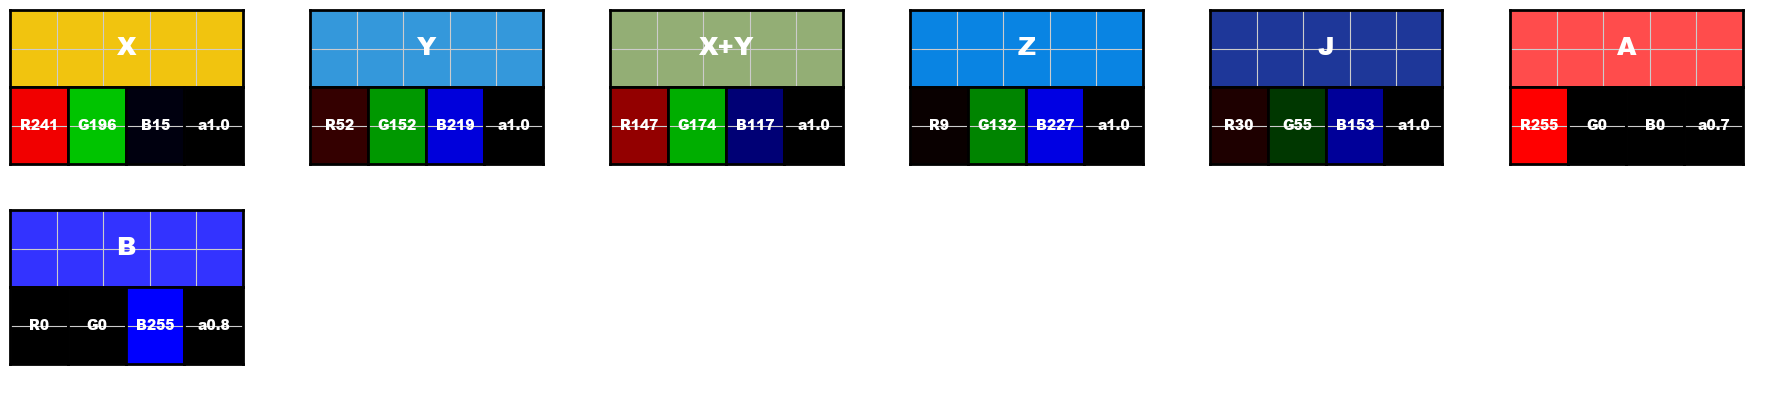

In [86]:
dfc = pd.DataFrame(
    columns=["Name", "R", "G", "B", "a"],
    data=[
        # https://flatuicolors.com/palette/defo
        # https://colorkit.io/
        # https://meyerweb.com/eric/tools/color-blend/#F1C40F:3498DB:1:hex
        ["X",   241, 196,  15, 1.],  # Sun Flower: F1C40E #f1c40f
        ["Y",    52, 152, 219, 1.],  # Peter River: 3398DB #3498db
        ["X+Y", 147, 174, 117, 1.],  # expectation: #92ae75 (RGB) #93ae75
        
        ["Z",  9, 132, 227, 1.],  # US: Electron Blue: #0984e3
        ["J", 30,  55, 153, 1.],  # FR: Electron Blue: #0984e3
        
        ["A", 255, 0,   0, 0.7], # transparent red
        ["B",   0, 0, 255, 0.8], # transparent blue
    ]
).set_index(["Name"])

display(dfc)

###############################################

dfc_l = len(dfc.index)
dfc_c = min(dfc_l, 6)
dfc_r = math.ceil(dfc_l / 6)

fig = plt.figure(figsize=(3 * dfc_c, 2 * dfc_r))
sfigs = fig.subfigures(dfc_r, dfc_c)

for i, (k, v) in enumerate(dfc.iterrows()):
    sfig = sfigs[i] if dfc_r <= 1 else sfigs[math.floor(i / 6)][i % 6]
    plt_comps(sfig, k, v)

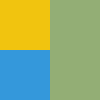

In [4]:
display(pil_2col(
  rgba("X")[:-1],
  rgba("Y")[:-1],
  rgba("X+Y")[:-1],
))

# Research
- Keywords:
  - Blend Modes, Additive Color Mixing, Subtractive Color Mixing, Color Blending, Color Mixing, Clamp addition on color, 
  - Computer RGB values, square root of photon flux, gamma correction, gray-scale gradient,
  - linear mixing, non-linear mixing, linear blending, non-linear blending,
  - Color Space, Color channels, Color Modes, Color Code, Color Models
- Consideration:
  - Alpha Channel, Computer RGB values, square root of photon flux, gamma correction, gamma-corrected space,
  - 
- Spaces: CMYK
- [Algorithm for Additive Color Mixing for RGB Values - Stack Overflow](https://stackoverflow.com/a/29321264)
- [What every coder should know about gamma | John Novak](https://blog.johnnovak.net/2016/09/21/what-every-coder-should-know-about-gamma/)
- [specifications - Algorithms for color blending modes: hue, saturation, color, luminosity - Software Engineering Stack Exchange](https://softwareengineering.stackexchange.com/questions/336794/algorithms-for-color-blending-modes-hue-saturation-color-luminosity)
- [Blend modes - Wikipedia](https://en.wikipedia.org/wiki/Blend_modes)
- [loilo/color-blend: 🎨 Blends RGBA colors with various blend modes in JavaScript](https://github.com/Loilo/color-blend)
- [algorithm - Mix two non-opaque colors with "hue" blend mode - Stack Overflow](https://stackoverflow.com/questions/40796852/mix-two-non-opaque-colors-with-hue-blend-mode)
- .
- https://opensource.adobe.com/dc-acrobat-sdk-docs/pdfstandards/PDF32000_2008.pdf
- https://opensource.adobe.com/dc-acrobat-sdk-docs/
- [opensource.adobe.com/dc-acrobat-sdk-docs/pdflsdk/index.html](https://opensource.adobe.com/dc-acrobat-sdk-docs/pdflsdk/index.html)
- [Adobe Open Source | Advancing technology through open initiatives](https://opensource.adobe.com/)

### Summary

- RGB Linear
- RGB by Fluctuation of Photon using Gamma Correction
- Not true blending on single unit color
- Should be when Red (#FF0000) mix with Green (#00FF00), should have (#FFFF00) with no color lost
- sRGB, color gamut, composition, interpolating, antialias, muted

[241 196  15]
(52, 152, 219)
[147 174 117]


<Axes: xlabel='x', ylabel='Y'>

(241, 196, 15)
(52, 152, 219)
[190, 45, 205]


<Axes: >

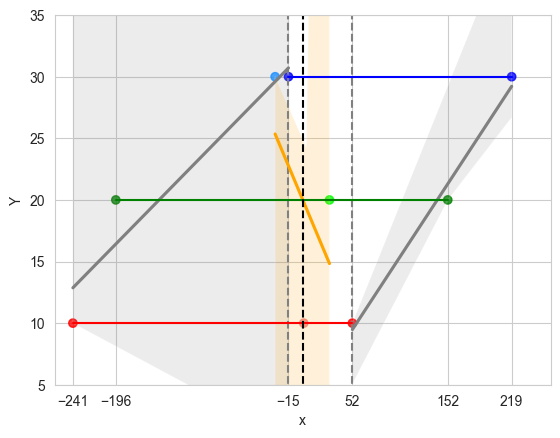

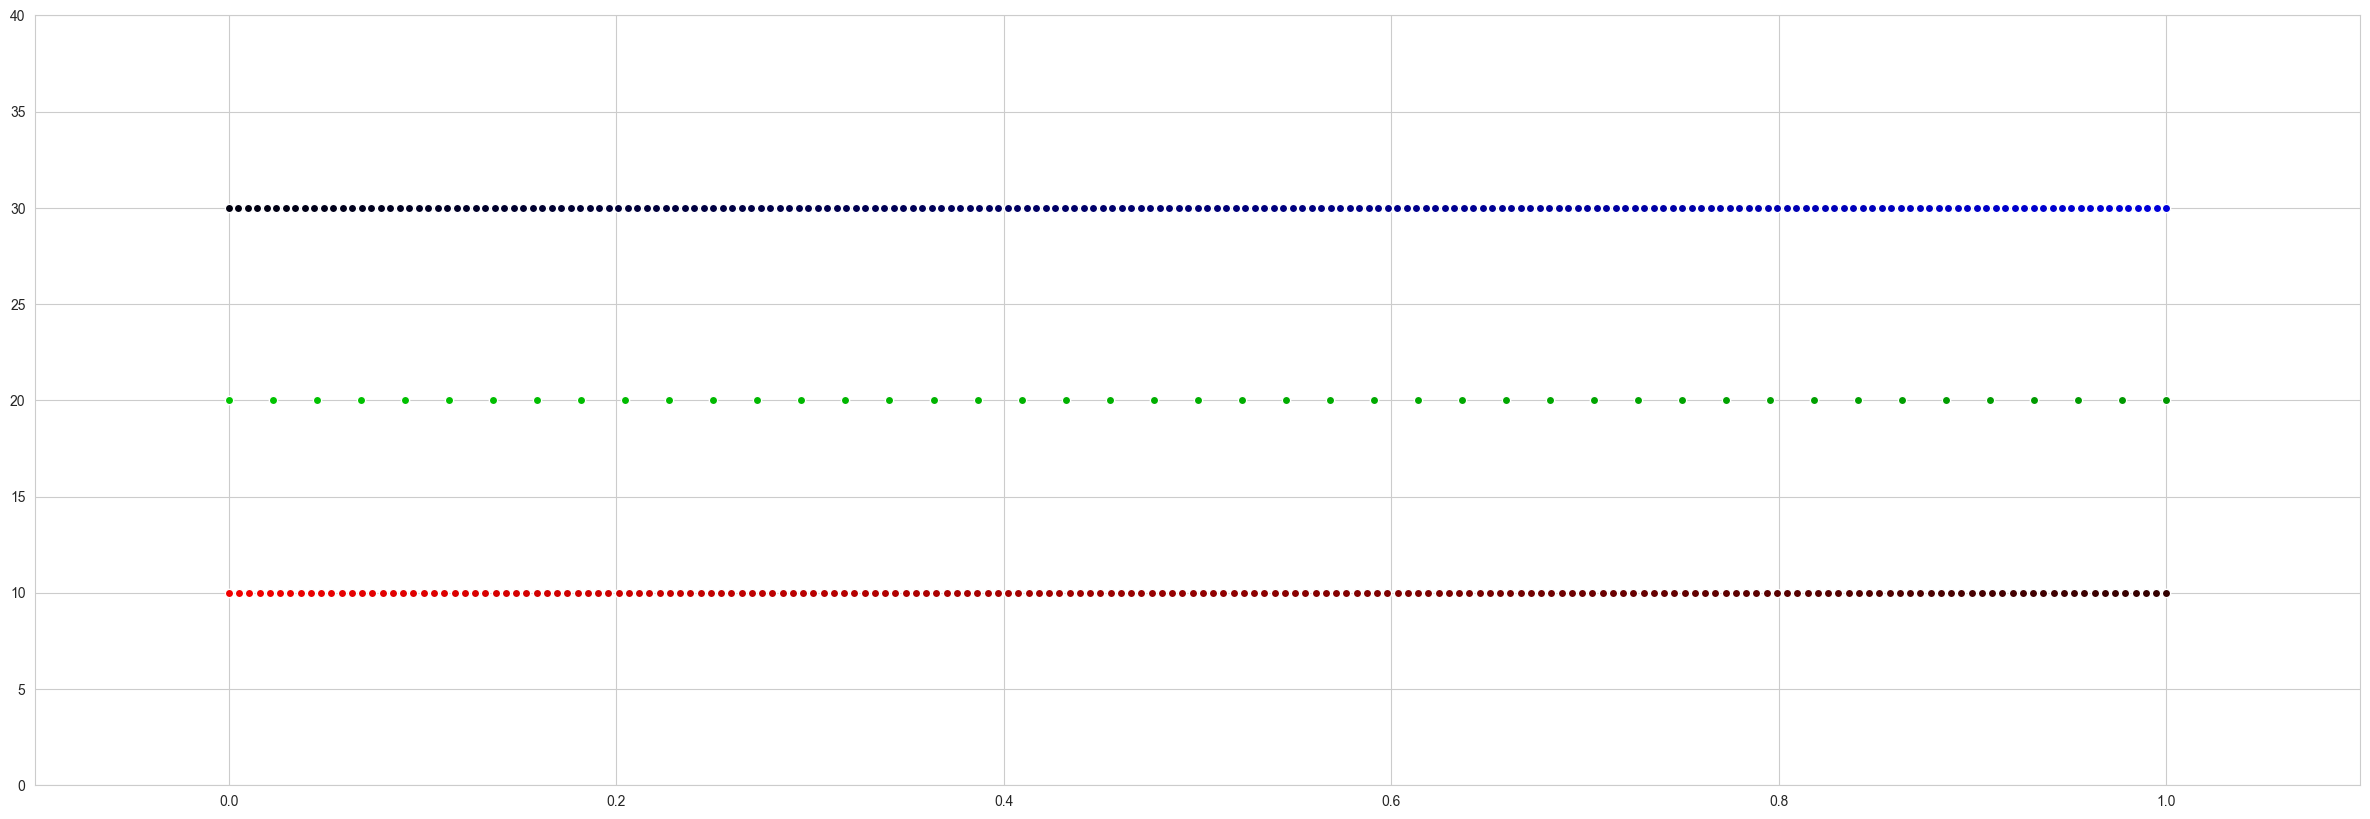

In [9]:
display(plt_3reg(rgba("X")[:-1], rgba("Y")[:-1], rgba("X+Y")[:-1]))
display(plt_prgb(
  rgba("X")[:-1],
  rgba("Y")[:-1],
))

In [5]:
def mix_colors_rgba(color_a, color_b, mode="mix", t=None, gamma=2.2):
    """
    Mix two colors color_a and color_b.

    Arguments:
        color_a:    Real-valued 4-tuple. Foreground color in "blend" mode.
        color_b:    Real-valued 4-tuple. Background color in "blend" mode.
        mode:       "mix":   Interpolate between two colors.
                    "blend": Blend two translucent colors.
        t:          Mixing threshold.
        gamma:      Parameter to control the gamma correction.

    Returns: 
        rgba:       A 4-tuple with the result color.

    To reproduce Markus Jarderot's solution:
            mix_colors_rgba(a, b, mode="blend", t=0, gamma=1.)
    To reproduce Fordi's solution:
            mix_colors_rgba(a, b, mode="mix", t=t, gamma=2.)
    To compute the RGB color of a translucent color on white background:
            mix_colors_rgba(a, [1,1,1,1], mode="blend", t=0, gamma=None)
    """
    assert(mode in ("mix", "blend"))
    assert(gamma is None or gamma>0)
    t = t if t is not None else (0.5 if mode=="mix" else 0.)
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    if mode=="mix" and gamma in (1., None):
        r, g, b, a = (1-t)*color_a + t*color_b
    elif mode=="mix" and gamma > 0:
        r,g,b,_ = np.power((1-t)*color_a**gamma + t*color_b**gamma, 1/gamma)
        a = (1-t)*color_a[-1] + t*color_b[-1]
    elif mode=="blend":
        alpha_a = color_a[-1]*(1-t)
        a = 1 - (1-alpha_a) * (1-color_b[-1])
        s = color_b[-1]*(1-alpha_a)/a
        if gamma in (1., None):
            r, g, b, _ = (1-s)*color_a + s*color_b
        elif gamma > 0:
            r, g, b, _ = np.power((1-s)*color_a**gamma + s*color_b**gamma,
                                  1/gamma)

    return tuple(np.clip([r,g,b,a], 0, 1))

In [308]:
def mix_colors_rgba_gen(color_a, color_b, t=None, gamma=0):
    t = t if t is not None else 0.5
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    r,g,b,_ = np.power((1-t)*color_a**gamma + t*color_b**gamma, 1/gamma)
    a = (1-t)*color_a[-1] + t*color_b[-1]
    return tuple(np.clip([r,g,b,a], 0, 1))

def blend_colors_rgba(color_a, color_b, t=None, gamma=0):
    t = t if t is not None else 0.5
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    
    alpha_a = color_a[-1]*(1-t)      # t=0; from 100% a and 0% b
    alpha_b = color_b[-1]*t
    
    # a = 1 - (1 - alpha_a) * (1 - color_b[-1])     # on-algo, by-code
    a = 1 - (1 - color_a[-1]) * (1 - color_b[-1])     # self-fix; this one feels good
    # a = 1 - (1 - alpha_a) * (1 - alpha_b)     # self-fix
    s = color_b[-1] * (1 - alpha_a) / a     # by-code
    # s = alpha_b * (1 - alpha_a) / a     # on-algo
    
    r,g,b,_ = np.power((1-s)*color_a**gamma + s*color_b**gamma, 1/gamma)
    return tuple(np.clip([r,g,b,a], 0, 1))

1 - 3 * 4

-11

In [ ]:
c = mix_colors_rgba(
    (1, 0, 0, 1),
    (0, 1, 0, 1),
    "blend", 0.5, 2.2
)

print(c)

# 0.7297400528407231 * 255
# 1 in (1., None)
# 1 == 1.
print([
    # c,
    math.ceil(3 / 6),
    3 * 2 ** 5,
    3*2** 5,
    3 * (2 ** 5),
    (3 * 2) ** 5,
])

(np.float64(0.7297400528407231), np.float64(0.7297400528407231), np.float64(0.0), np.float64(1.0))
[1, 96, 96, 96, 7776]


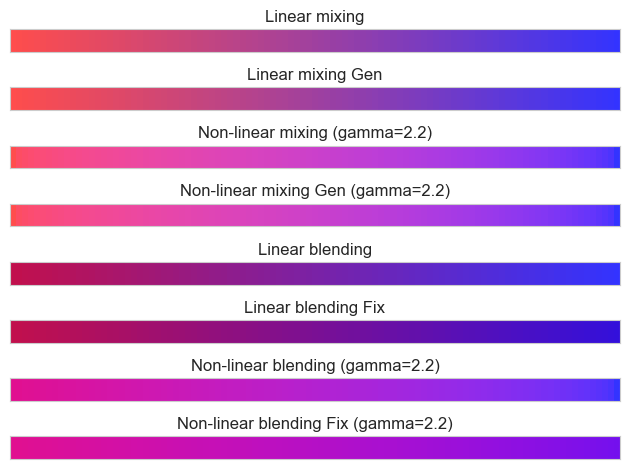

In [310]:
_, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8,ncols=1)

n = 101
ts = np.linspace(0,1,n)
color_a = [1.0,0.0,0.0,0.7] # transparent red
color_b = [0.0,0.0,1.0,0.8] # transparent blue

plot_fill([mix_colors_rgba(color_a, color_b, t=t, mode="mix", gamma=None)
      for t in ts], ax=ax1, title="Linear mixing")
plot_fill([mix_colors_rgba_gen(color_a, color_b, t=t, gamma=1) for t in ts],
      ax=ax2, title="Linear mixing Gen")
plot_fill([mix_colors_rgba(color_a, color_b, t=t, mode="mix", gamma=2.2)
      for t in ts], ax=ax3, title="Non-linear mixing (gamma=2.2)")
plot_fill([mix_colors_rgba_gen(color_a, color_b, t=t, gamma=2.2) for t in ts], 
      ax=ax4, title="Non-linear mixing Gen (gamma=2.2)")

plot_fill([mix_colors_rgba(color_a, color_b, t=t, mode="blend", gamma=None)
      for t in ts], ax=ax5, title="Linear blending")
plot_fill([blend_colors_rgba(color_a, color_b, t=t, gamma=1)
      for t in ts], ax=ax6, title="Linear blending Fix")

plot_fill([mix_colors_rgba(color_a, color_b, t=t, mode="blend", gamma=2.2)
      for t in ts], ax=ax7, title="Non-linear blending (gamma=2.2)")
plot_fill([blend_colors_rgba(color_a, color_b, t=t, gamma=2.2)
      for t in ts], ax=ax8, title="Non-linear blending Fix (gamma=2.2)")

plt.tight_layout()
plt.show()

(<Figure size 100x100 with 1 Axes>, <Axes: >)

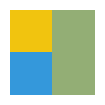

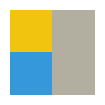

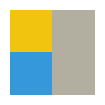

In [183]:
plt_2col(be_C01(X_RGB), be_C01(Y_RGB), be_C01(Z_RGB))
plt_2col(be_C01(X_RGB), be_C01(Y_RGB), mix_colors_rgba_gen(be_C01(X_RGB), be_C01(Y_RGB), t=0.5, gamma=2.2))
plt_2col(be_C01(X_RGB), be_C01(Y_RGB), blend_colors_rgba(be_C01(X_RGB), be_C01(Y_RGB), t=0.5, gamma=2.2))

In [99]:
n = 21
print(np.arange(n))
print([int(n*0.20), 1])
print()
print(np.tile(np.arange(n), [int(n*0.20), 1]))
print(np.tile([7, 8, 9], [3, 2]))
print(np.tile(7, 3))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4, 1]

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]]
[[7 8 9 7 8 9]
 [7 8 9 7 8 9]
 [7 8 9 7 8 9]]
[7 7 7]


- [Math and equations | Jupyter Notebook](https://jupyterbook.org/en/stable/content/math.html)
- [Writing mathematical expressions - GitHub Docs](https://docs.github.com/en/get-started/writing-on-github/working-with-advanced-formatting/writing-mathematical-expressions)
- [LaTeX/Mathematics - Wikibooks, open books for an open world](https://en.wikibooks.org/wiki/LaTeX/Mathematics)

Formulas on RGB considering Gammas:
- Linear mixing ( $\gamma$=1) (t=threashold from x(0.0) to y(1.0)):
  - RGB $\alpha$ :    $(1-t)x + ty$
- Non-linear mixing (gama≠1):
  - r,g,b:      $[(1-t)*x^{\gamma} + t*y^{\gamma}]^{\frac{1}{\gamma}}$
  - a:          $[(1-t)*x_\alpha] + (t*y_\alpha)$
- Blending ( $\gamma$ = 1):
  - a:          $1 - [1-(1-t)*x]*(1-y)$
  - s:          $\alpha_y * \frac{1 - \alpha_x}{\alpha_{xy}}$
  - r,g,b:      $(1-s)*x + s*y$



- Blending ( $\gamma$≠1):
  - $\alpha_{xy}$:          $1 - \Big([1-(1-t)*x_\alpha] * (1 - y_\alpha)\Big)$
  - s:          $(t * y_\alpha) * \frac{1 - ([1-t] * x_\alpha)}{\alpha_{xy}}$
  - r,g,b:      $[(1-s)*x^{\gamma} + s*y^{\gamma}]^{\frac{1}{\gamma}}$

Generalization $I$:
- $\alpha_{xy}$: $[(1-t)*x] + (t*y)$
- RGB: $[(1-t)*x^{\gamma} + t*y^{\gamma}]^{\frac{1}{\gamma}}$

Generalization $II$
- $\alpha_{xy}$: ...
- RGB: $[(1-s)*x^{\gamma} + s*y^{\gamma}]^{\frac{1}{\gamma}}$

# Notes

> [Color Spaces, clarkvision.com](https://clarkvision.com/articles/color-spaces/)
> this article is copyrighted

- color space: https://clarkvision.com/articles/color-spaces/color-rgb-xy-cie1931-diagram1mjfjl-waveticks-c1+drkcontours-3led-flashlights.jpg

<!-- <img src="https://clarkvision.com/articles/color-spaces/color-rgb-xy-cie1931-diagram1mjfjl-waveticks-c1+drkcontours-3led-flashlights.jpg" alt="" width="800"> -->

- [colour · PyPI](https://pypi.org/project/colour/);  [blend-modes · PyPI](https://pypi.org/project/blend-modes/);  [scrtwpns/mixbox: Mixbox is a library for natural color mixing based on real pigments.](https://github.com/scrtwpns/mixbox);  [mattrobenolt/colors.py: Colors aren't that scary!](https://github.com/mattrobenolt/colors.py);  [flrs/blend_modes: Python package that implements image blend modes](https://github.com/flrs/blend_modes);  [edaniszewski/colorutils: A library which provides utilities for working with colors in Python](https://github.com/edaniszewski/colorutils);  [color-blend - npm](https://www.npmjs.com/package/color-blend);  colorsys
- [HTML Color Codes](https://htmlcolorcodes.com/)

<img src="https://i.sstatic.net/KBaHl.png" alt="" width="400">
<img src="https://astro101.wwu.edu/101/light_spectrum.jpg" alt="" width="400">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/1416_Color_Sensitivity.svg/1920px-1416_Color_Sensitivity.svg.png" alt="" width="400">

**Keywords:**

- color cube
- ceil of / 255
- revert gamma correction
- cielab, L*a*b*, cie xyz color space, oklab, cielch, oklch, LCh
- LCh > Lab > XYZ > sRGB
- perceptual weughting models for color difference formula
- color quantization, dominant color extration
- hue preserving blending models, color harmonization techiques,
- coloraide, imagemagick,
- chroma
- Photoshop use 1.42 for antialiasing

---

- [Color CIE Chromaticity and Perception, clarkvision.com](https://clarkvision.com/articles/color-cie-chromaticity-and-perception/)
- [A Beginner’s Guide to (CIE) Colorimetry | by Chandler Abraham | Color and Imaging | Medium](https://medium.com/hipster-color-science/a-beginners-guide-to-colorimetry-401f1830b65a)
  - [Color for the Sciences | Mitpress Book](https://mitpress.mit.edu/books/color-sciences)
  - cie colorimetry, theoretical colorimetry, color matching system, color reproduction, cie's implementation, color discrimination,  opponent color theory, metamerism, ramifications, spectral color, spectral locus, CIE XYZ Color Space, XYZ/RGB Color Matching Functions, Luminosity Function, color gamut, Color Difference Models, perceptual uniformity 
  - If you draw a line between any two points on the curve, the midpoint is the chromaticities of mixing those two spectral chromaticities.
  - Hue
    ```
    R   G B  R
       Y C  M
     O     P
    ```
- [Color for the Sciences | #9780262014281 | Mitpress Book](https://mitpress.mit.edu/9780262014281/color-for-the-sciences/)
- [Opponent process - Wikipedia](https://en.m.wikipedia.org/wiki/Opponent_process)
- [IrfanView - Official Homepage - One of the Most Popular Viewers Worldwide](https://www.irfanview.com/)

# Experiment: RGB Mix by Unit Color
- RGB Stacking (on Black Paper) and Normalizing with dropping non-fluctuating photon (root of gamma; drop below 0)
- CYM on White Paper and Black Tint
- RBY of Primary Color
- Human Retina Receptors (Photoreceptor cell)
  - Its turn out, those only RGB and Black

## RGB Stacking (Black Paper and Inverse-Gamma)

![LED](https://garethedwill.wordpress.com/wp-content/uploads/2011/02/sd-lcd.jpg)

- Black Paper
- Normalizing with dropping non-fluctuating photon (root of gamma; drop below 0)
- Synthetic/Digital Colors

Question:
- what if majority colors below 4?
- What is the lowest photons until LED cannot lighten?

Solution:
- the brigthes should on the center
- The surrounding should not have similar color
- Its turn out to always have hexagones shapes
- From RGB, drop the lowest? or drop the outsider?

![image](./ColorBlendAlgorithm/AI-Related-Color%20Blending.png)

### RGB: Hypothesis 1: exploding 2.2 photon power
- I should assume Y+C=G
- So, Y+C+B=G+B=Y
- I've been misconception; RGB+RGB=CMYK (Addictive); CMYK - CMYK = RGB (subtractive);

![Molecular Expressions: Science, Optics, and You: Light and Color - Primary Colors](https://micro.magnet.fsu.edu/optics/lightandcolor/images/primaryfigure1.jpg)

```py
# rgba(251, 197,  49, 1.0) Yellow
# rgba(  0, 168, 255, 1.0) Cyan

np.array([[1., 1., 0.], # R+G+0=Y
          [0., 1., 1.], # 0+G+B=C
          
          [1., 0., 0.], # R+0+0=R
          [0., 0., 1.], # 0+0+B=B

          [0., 0., 0.], # Y+C+B = (R+G) + (G+B) + B = G+B = Y
        ])
```

Proposal 1:

1. remove every number below 6^2.2
2. Filter color with 1 component most significant to allow RGB addiction
3. Filter color with 2 component most significant to allow CMYK subtraction
4. Filter color with 3 component most significant to allow Gray selection

[1.0,
 1.3703509847201236,
 12.41314704969278,
 49.51611990654414,
 None,
 [195.4627062104636, 41, 236.7002634504806, 19],
 [243.98467976880693, 8, 251.2340119495944, 4],
 None,
 21.112126572366314,
 34.493241536530384]

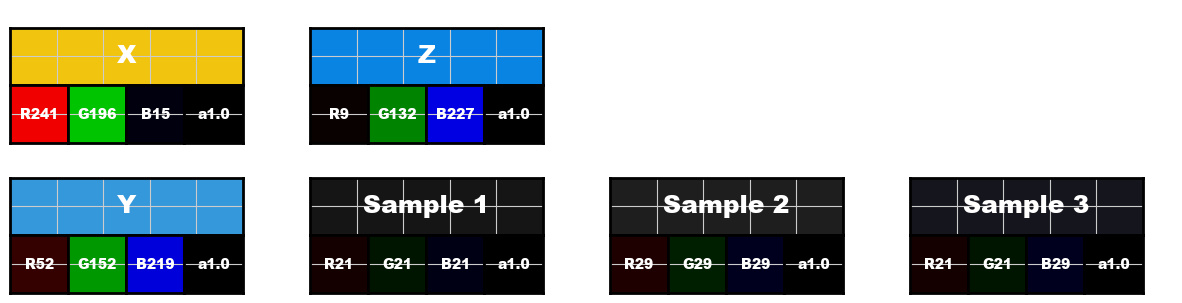

In [187]:
display([
    1 ** (1/2.2),
    2 ** (1/2.2),
    255 ** (1/2.2),
    255 ** (1/1.42),
    None,
    [11 ** 2.2, 236 - 195, 12 ** 2.2, 255 - 236],
    [48 ** 1.42, 251 - 243, 49 ** 1.42, 255 - 251],
    None,
    4 ** 2.2,
    5 ** 2.2,
])

fig = plt.figure(figsize=(3 * 4, 3))
figs = fig.subfigures(2, 4)

plt_comps(figs[0][0], "X", dfc.loc["X"])
plt_comps(figs[0][1], "Z", dfc.loc["Z"])

plt_comps(figs[1][0], "Y", dfc.loc["Y"])
plt_comps(figs[1][1], "Sample 1", pd.Series([4 ** 2.2, 4 ** 2.2, 4 ** 2.2, 1.]))
plt_comps(figs[1][2], "Sample 2", pd.Series([1.4 * (4 ** 2.2), 1.4 * (4 ** 2.2), 1.4 * (4 ** 2.2), 1.]))
plt_comps(figs[1][3], "Sample 3", pd.Series([4 ** 2.2, 4 ** 2.2, 1.4 * (4 ** 2.2), 1.]))

,R,G,B,a
Name,,,,
X,241.0,196,NaN,1.0
Z,NaN,132,227.0,NaN


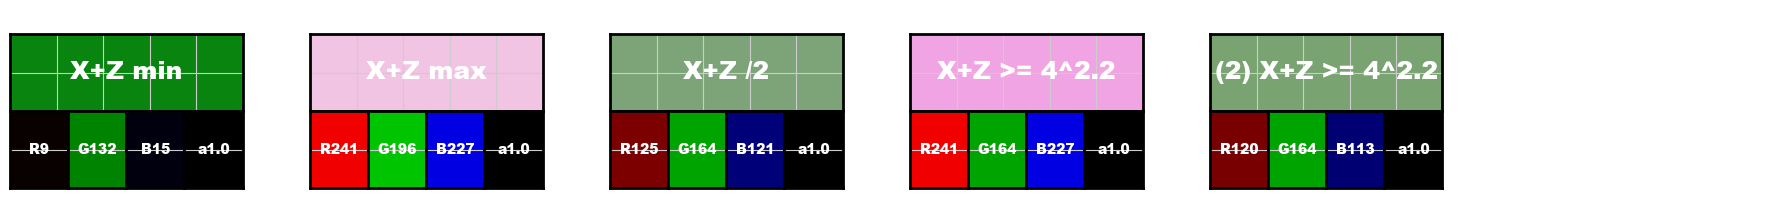

In [275]:
fig = plt.figure(figsize=(3 * 6, 2))
figs = fig.subfigures(1, 6)

plt_comps(figs[0], "X+Z min", dfc.loc[["X", "Z"]].min(axis=0))
plt_comps(figs[1], "X+Z max", dfc.loc[["X", "Z"]].max(axis=0))
plt_comps(figs[2], "X+Z /2", dfc.loc[["X", "Z"]].sum(axis=0) / 2)

# ####################

new_col_s = dfc.loc[["X", "Z"]].copy(True)

new_col_s[new_col_s.loc[["X", "Z"], ["R", "G", "B"]] <= 4 ** 2.2] = None
new_col_s.loc[new_col_s.index[1:], ["a"]] = None

new_col_s_1 = new_col_s.sum(axis=0, skipna=True)
new_col_s_1.loc[["G"]] /= 2

plt_comps(figs[3], "X+Z >= 4^2.2", new_col_s_1)

# ####################

display(new_col_s)
plt_comps(figs[4], "(2) X+Z >= 4^2.2", pd.Series([*(new_col_s.sum(axis=0, skipna=True).iloc[:-1] / 2).tolist(), 1.]))

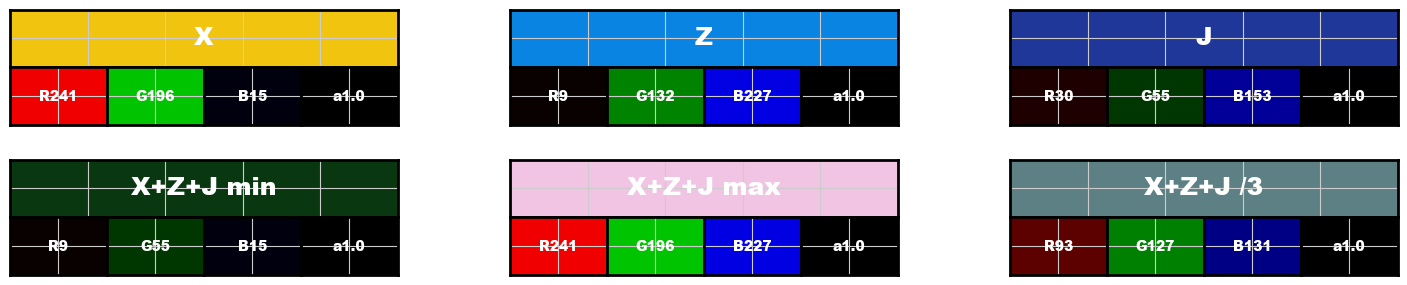

In [324]:
fig = plt.figure(figsize=(3 * 5, 3))
figs = fig.subfigures(2, 3)

plt_comps(figs[0][0], "X", dfc.loc["X"])
plt_comps(figs[0][1], "Z", dfc.loc["Z"])
plt_comps(figs[0][2], "J", dfc.loc["J"])

# ####################

plt_comps(figs[1][0], "X+Z+J min", dfc.loc[["X", "Z", "J"]].min(axis=0))
plt_comps(figs[1][1], "X+Z+J max", dfc.loc[["X", "Z", "J"]].max(axis=0))
plt_comps(figs[1][2],  "X+Z+J /3", dfc.loc[["X", "Z", "J"]].sum(axis=0) / 3)

,R,G,B,a
Name,,,,
X,241.0,196,NaN,1.0
Z,NaN,132,227.0,NaN
J,30.0,55,153.0,NaN


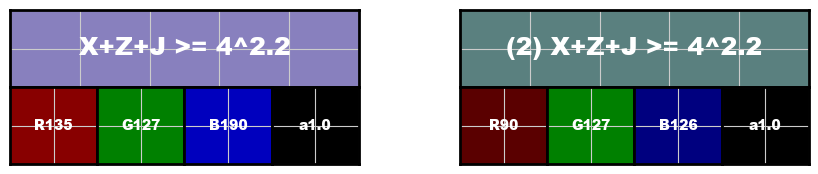

In [326]:
fig = plt.figure(figsize=(3 * 3, 2))
figs = fig.subfigures(1, 2)

####

new_col_s = dfc.loc[["X", "Z", "J"]].copy(True)

new_col_s[new_col_s.loc[["X", "Z", "J"], ["R", "G", "B"]] <= 4 ** 2.2] = None
new_col_s.loc[new_col_s.index[1:], ["a"]] = None

display(new_col_s)

new_col_s_1 = new_col_s.sum(axis=0, skipna=True)
new_col_s_1.loc[["R", "B"]] /= 2
new_col_s_1.loc[["G"]] /= 3

plt_comps(figs[0], "X+Z+J >= 4^2.2", new_col_s_1)

# ####################

plt_comps(figs[1], "(2) X+Z+J >= 4^2.2", pd.Series([*(new_col_s.sum(axis=0, skipna=True).iloc[:-1] / 3).tolist(), 1.]))

,R,G,B,a
Name,,,,
X,241.0,196,NaN,1.0
Z,NaN,132,227.0,NaN
J,NaN,55,153.0,NaN


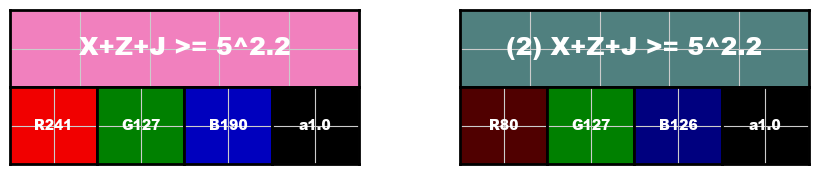

In [328]:
fig = plt.figure(figsize=(3 * 3, 2))
figs = fig.subfigures(1, 2)

####

new_col_s = dfc.loc[["X", "Z", "J"]].copy(True)

new_col_s[new_col_s.loc[["X", "Z", "J"], ["R", "G", "B"]] <= 5 ** 2.2] = None
new_col_s.loc[new_col_s.index[1:], ["a"]] = None

display(new_col_s)

new_col_s_1 = new_col_s.sum(axis=0, skipna=True)
new_col_s_1.loc[["B"]] /= 2
new_col_s_1.loc[["G"]] /= 3

plt_comps(figs[0], "X+Z+J >= 5^2.2", new_col_s_1)

# ####################

plt_comps(figs[1], "(2) X+Z+J >= 5^2.2", pd.Series([*(new_col_s.sum(axis=0, skipna=True).iloc[:-1] / 3).tolist(), 1.]))

### RGB: Proposal 2: Addition by Ceil Up Nearest Box

In [305]:
df2 = dfc[["R", "G", "B"]].loc[["X", "Z", "J"]].copy(True).reset_index()

for i in df2.index:
    df2.loc[i + 0.1] = [
        f'{df2.loc[i]["Name"]}_block',
        255 - df2.loc[i]["R"],
        255 - df2.loc[i]["G"],
        255 - df2.loc[i]["B"],
    ]

df2 = df2.sort_index().set_index(["Name"])
display(df2)

# fig = plt.figure(figsize=(3 * 5, 3))
# figs = fig.subfigures(1, 3)

# plt_comps(figs[0], "X", dfc.loc["X"])
# plt_comps(figs[1], "Z", dfc.loc["Z"])
# plt_comps(figs[2], "J", dfc.loc["J"])

,R,G,B
Name,,,
X,241,196,15
X_block,14,59,240
Z,9,132,227
Z_block,246,123,28
J,30,55,153
J_block,225,200,102


395 2


R    280
G    383
B    395
dtype: int64

R    140.0
G    191.5
B    197.5
a      1.0
dtype: float64

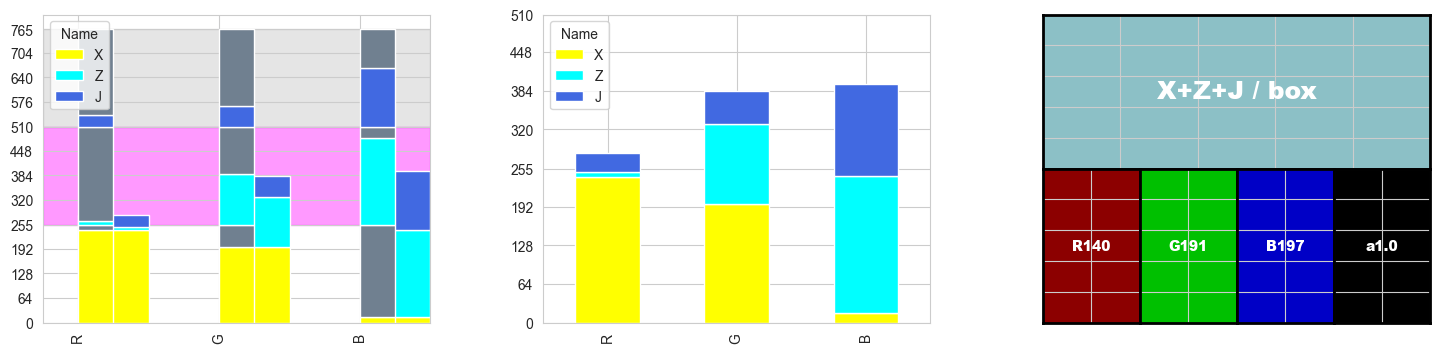

In [ ]:
fig = plt.figure(figsize=(3 * 5, 4))
figs = fig.subfigures(1, 3)

ax = figs[0].subplots()
# fig, ax = plt.subplots(figsize=(6, 4))

y = np.array([64 * i for i in range (0, 12)] + [255 * i for i in range (1, 4)])
y = y[(y % 256 != 0) | (y == 0)]
y.sort()

ax.set_yticks(y)

ax.axhspan(510, 765, color='grey', alpha=0.2, zorder=0)
ax.axhspan(255 * 1, 255 * 2, color='magenta', alpha=0.4, zorder=0)
# ax.axhspan(255 * 0, 255 * 1, color='gold', alpha=0.4, zorder=0)

# why df2? think df and df1 are always already been reserved
df2.loc[["X", "Z", "J"]].transpose().plot(kind="bar", stacked=True, color=["yellow", "cyan", "royalblue"], ax=ax, align="edge")
df2.transpose().plot(kind="bar", stacked=True, color=["yellow", "slategray", "cyan", "slategray", "royalblue", "slategray"], width=.25, ax=ax, align="edge", legend=False) 

# ####################################################################

ax = figs[1].subplots()

df2.loc[["X", "Z", "J"]].transpose().plot(kind="bar", stacked=True, color=["yellow", "cyan", "royalblue"], ax=ax)
ax.set_yticks(y[y <= 255 * 2])

# #############################################

series_rgb = df2.loc[["X", "Z", "J"]].sum()
rgb_max = series_rgb.max()
max_box = math.ceil(rgb_max / 255)
max_rgba = series_rgb / max_box
max_rgba["a"] = 1.0

print(rgb_max, max_box)
display(series_rgb)
display(max_rgba)
# display(max_rgba.loc[0])

plt_comps(figs[2], "X+Z+J / box", max_rgba)

### RGB Proposal 3: Addition by Highest Sum as 255

- By (2) and (3). It much logical, when dark and light combined would complement each other, not increasing their value. As such, it much more logical on greedy substitution rather than by filled box or highest value.
- I have no much reference or control variable to compare these data

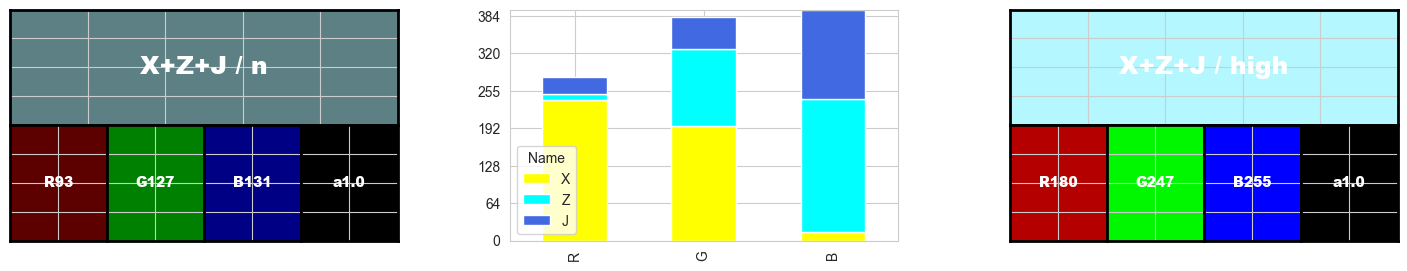

In [182]:
fig = plt.figure(figsize=(3 * 5, 3))
figs = fig.subfigures(1, 3)

ax = figs[1].subplots()
df2.loc[["X", "Z", "J"]].transpose().plot(kind="bar", stacked=True, color=["yellow", "cyan", "royalblue"], ax=ax)
ax.set_yticks(y[y <= rgb_max])
ax.set_ylim(0, rgb_max)

# ################################

max_rgba = series_rgb * 255 / rgb_max
max_rgba["a"] = 1.0

plt_comps(figs[2], "X+Z+J / high", max_rgba)

# ################################

max_rgba = series_rgb / 3
max_rgba["a"] = 1.0

plt_comps(figs[0], "X+Z+J / n", max_rgba)

### RGB: Proposal 4: The Density of Alpha with L50% Assumptions

**HLa white**
- H0 L100% a0%
- H0 L50% a100%

**HLa black**
- H0 L0% a0%
- H0 L50% a100%

**Algo:** HLA black -> ax -> Lx a100% -> L50% ax
- black is better because when H0 L30, it lower the R in RGB; instead L70 it increase G and B 
- Or just convert the R into a? Hmm...
- Yes, after testing, the `R / 255` is equal to `lightness / 0.5` on li is below 0.5.

**\[Update 2025-05-31]** I got it. How to implement density. And create a control/reference variable
- assume the lowest number is equal to 1 dot.
- would not works, as everything is 255. How to implement density?

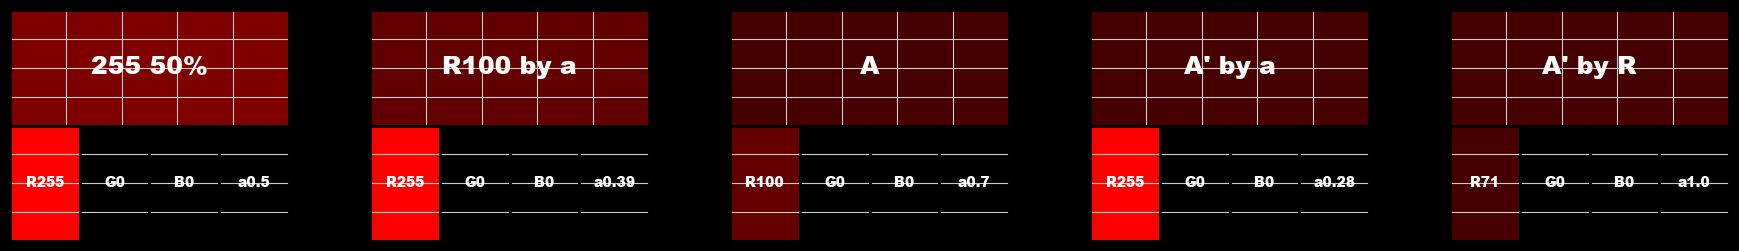

In [ ]:
fig = plt.figure(figsize=(3 * 6, 3))
fig.set_facecolor("black")
figs = fig.subfigures(1, 5)

plt_comps(figs[0], "255 50%", c_ss(255, 0, 0, 0.5))
plt_comps(figs[1], "R100 by a", c_ss(255, 0, 0, .39))
plt_comps(figs[2], "A", c_ss(100, 0, 0, 0.7))
plt_comps(figs[3], "A' by a", c_ss(255, 0, 0, 0.28))
plt_comps(figs[4], "A' by R", c_ss(255 * 0.28, 0, 0, 1.))

In [302]:
c = c_ss(100, 0, 0, 0.7)

# a = (c["R"] * c["a"] / 255)
a = c["R"] / 255

print("initial: ", a)

a = a * c["a"]

print("post: ", a)
display(c)

initial:  0.39215686274509803
post:  0.2745098039215686


R    100.0
G      0.0
B      0.0
a      0.7
Name: 0, dtype: float64

In [301]:
c_hls = colorsys.rgb_to_hls(*(c[["R", "G", "B"]]) / 255)
c_li = c_hls[1] / .5 # normalize .0 - .5 to 0. - 1.
print(c_li)

0.39215686274509803


In [338]:
df2 = dfc.loc[["X", "Z", "J"], ["R", "G", "B"]].copy() / 255
display(df2)
display(df2.floordiv(df2.min().min()))
display(df2.floordiv(df2.min()))

# fig = plt.figure(figsize=(3 * 5, 3))
# figs = fig.subfigures(1, 3)

# plt_comps(figs[0], "X", dfc.loc["X"])
# plt_comps(figs[1], "Z", dfc.loc["Z"])
# plt_comps(figs[2], "J", dfc.loc["J"])

,R,G,B
Name,,,
X,0.945098,0.768627,0.058824
Z,0.035294,0.517647,0.890196
J,0.117647,0.215686,0.600000


,R,G,B
Name,,,
X,26.0,21.0,1.0
Z,1.0,14.0,25.0
J,3.0,6.0,16.0


,R,G,B
Name,,,
X,26.0,3.0,1.0
Z,1.0,2.0,15.0
J,3.0,1.0,10.0


### RGB: Hypothesis 2: Group by 12 photon

## More Notes

- [c# - Color Mixing for more than 2 colors - Stack Overflow](https://stackoverflow.com/questions/13200751/color-mixing-for-more-than-2-colors)
- [Dither - Wikipedia](https://en.wikipedia.org/wiki/Dither#Digital_photography_and_image_processing)
- [Is there an algorithm for color mixing that works like mixing real colors? - Stack Overflow](https://stackoverflow.com/questions/1351442/is-there-an-algorithm-for-color-mixing-that-works-like-mixing-real-colors)
- [Next Level Paint Simulations Are Coming! 🎨🖌️ - YouTube](https://www.youtube.com/watch?v=b2D_5G_npVI)

Keywords: Dithering, HSV

- I try to solve this using HSL, but I need to simulate the darkness where when the light colors touch the dark color, it would darken or lighter due of density.
- I named it K-NN Hue-Lightness and K-NN Hue-Saturation
- In this experiment, there is issue impacting Saturation or Grey Color. How local regional of Saturation can be fixed.
- As such, HSV comes to be hero. Seems, there is no need for local regional algorithm because grey is just 50% of light.
- In using RGB, I cannot determined did such color is not used or is actually black/darkened.

..

- [Perceiving the average hue of color arrays](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-31-4-a283)
- [How to get average hue of two colors? : r/processing](https://www.reddit.com/r/processing/comments/sfropf/how_to_get_average_hue_of_two_colors/)

### Use HSV

In [82]:
df2 = dfc[["R", "G", "B"]].loc[["X", "Z", "J"]].copy()

df2[["H", "S", "V"]] = df2.T.apply(lambda x: colorsys.rgb_to_hsv(x["R"] / 255., x["G"] / 255., x["B"] / 255.)).T
df2[["H", "S", "V"]] = df2.T.apply(lambda x: [x["H"] * 360, x["S"] * 100, x["V"] * 100]).T
df2[["H_pi"]] = df2.T.apply(lambda x: [x["H"] * math.pi / 180]).T
df2[["Hx", "Hy"]] = df2.T.apply(lambda x: [math.cos(x["H_pi"]), math.sin(x["H_pi"])]).T

df2

,R,G,B,H,S,V,H_pi,Hx,Hy
Name,,,,,,,,,
X,241,196,15,48.053097,93.775934,94.509804,0.838685,0.668442,0.743765
Z,9,132,227,206.146789,96.035242,89.019608,3.597940,-0.897668,-0.440672
J,30,55,153,227.804878,80.392157,60.000000,3.975945,-0.671658,-0.740862


In [83]:
m = df2[["Hx", "Hy", "S", "V"]].mean()
m["H"] = math.atan2(m["Hy"], m["Hx"]) * 180 / math.pi
m["H"] += 360

rgb_o = np.array(colorsys.hsv_to_rgb(m["H"]/ 360, m["S"] / 100, m["V"] / 100)) * 255
# rgb_o = np.array(colorsys.hsv_to_rgb(160 / 360, m["S"] / 100, m["V"] / 100)) * 255
rgb_o = np.concat([rgb_o, [1.0]])

display(m[["H", "S", "V"]])
display(rgb_o)

H    205.916664
S     90.067778
V     81.176471
dtype: float64

array([ 20.55970039, 126.46815779, 207.        ,   1.        ])

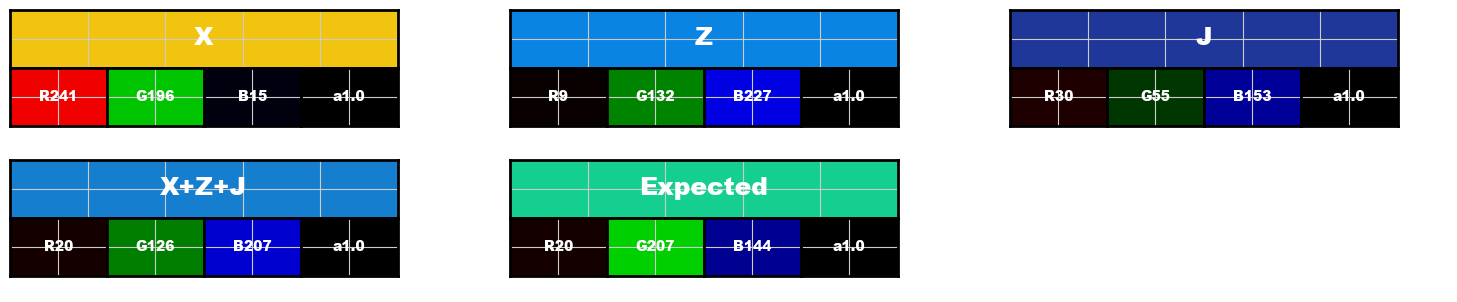

In [84]:
fig = plt.figure(figsize=(3 * 5, 3))
figs = fig.subfigures(2, 3)

plt_comps(figs[0][0], "X", dfc.loc["X"])
plt_comps(figs[0][1], "Z", dfc.loc["Z"])
plt_comps(figs[0][2], "J", dfc.loc["J"])

# ####################

df3 = dfc.loc[[]].copy()

rgb_o_2 = np.array(colorsys.hsv_to_rgb(160 / 360, m["S"] / 100, m["V"] / 100)) * 255
rgb_o_2 = np.concat([rgb_o_2, [1.0]])

plt_comps(figs[1][0], "X+Z+J", c_ss(*rgb_o))
plt_comps(figs[1][1], "Expected", c_ss(*rgb_o_2))

### Use HSV with Saturation and Value considered

- seems wrong the calculation before, because only take Hue as consideration.
- Now, we need to consider Saturation because it is the radius of Hue

In [70]:
df3 = df2.copy()

df3[["Hx", "Hy"]] = df3.T.apply(lambda x: [x["Hx"] * x["S"], x["Hy"] * x["S"]]).T

df3

,R,G,B,H,S,V,H_pi,Hx,Hy
Name,,,,,,,,,
X,241,196,15,48.053097,93.775934,94.509804,0.838685,62.683738,69.747220
Z,9,132,227,206.146789,96.035242,89.019608,3.597940,-86.207765,-42.320078
J,30,55,153,227.804878,80.392157,60.000000,3.975945,-53.995996,-59.559477


In [78]:
m = df3[["Hx", "Hy", "V"]].mean()

m["S"] = math.sqrt((m["Hx"] ** 2) + (m["Hy"] ** 2))
m["H"] = math.atan2(m["Hy"] / m["S"], m["Hx"] / m["S"]) * 180 / math.pi
m["H"] += 360

rgb_o = np.array(colorsys.hsv_to_rgb(m["H"]/ 360, m["S"] / 100, m["V"] / 100)) * 255
rgb_o = np.concat([rgb_o, [1.0]])

display(m[["H", "S", "V"]])
display(rgb_o)

H    202.514186
S     27.971893
V     81.176471
dtype: float64

array([149.09818234, 185.27312813, 207.        ,   1.        ])

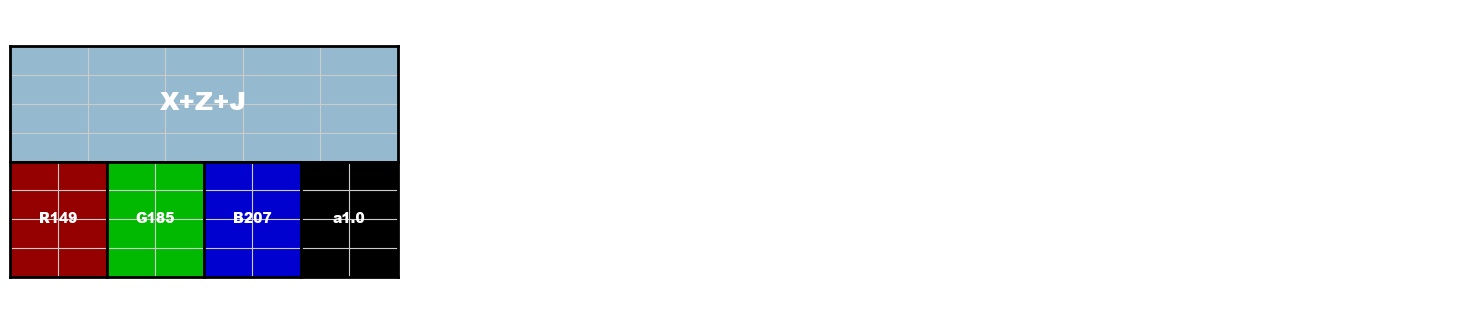

In [79]:
fig = plt.figure(figsize=(3 * 5, 3))
figs = fig.subfigures(1, 3)

df3 = dfc.loc[[]].copy()

plt_comps(figs[0], "X+Z+J", c_ss(*rgb_o))

Are you kidding me? What am I even doing?

I think we should not consider Saturation?

## Simulate on pixelated

I don't know what I am doing. This is the best way to prove. And this is the expected version.

256


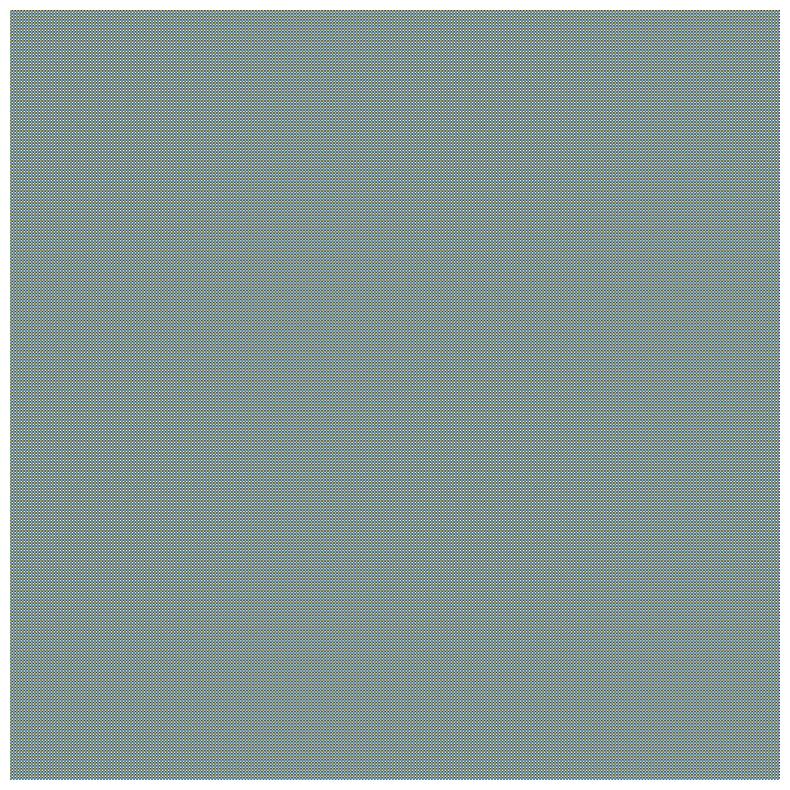

In [130]:
df2 = dfc.loc[["X", "Z", "J"]].copy()

df2[["R", "G", "B"]] = df2[["R", "G", "B"]] / 255

arr1 = np.array([
  [df2.loc["X"], df2.loc["J"]],
  [df2.loc["Z"], [0., 0., 0., 0.]],
])

tile = 2 ** 8
print(tile)
arr1 = np.tile(arr1, (tile, tile, 1))

# =====================================

fig, ax = plt.subplots(figsize=(8, 8))
# fig.patch.set_facecolor("black")
# fig.patch.set_facecolor("white")
ax.imshow(arr1,
          # origin='upper', 
          # origin='lower', 
          # extent=[-1, 1, -1, 1]
          # extent=[-1, 0, -1, 0]
)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.show()